In [8]:
import numpy as np
import pandas as pd
import sklearn.manifold
import sklearn.decomposition
import matplotlib.pyplot as plt
%matplotlib inline

In [166]:
expr_matrix = pd.read_csv("../filtered_genes_FPKM.csv", header=0, index_col=0)

In [174]:
expr_matrix=expr_matrix.drop(['TCGA-5M-AAT5', 'TCGA-5M-AATA', 'TCGA-F5-6810'],axis=1)
print(expr_matrix.shape)

In [302]:
metadata = pd.read_csv("../../data/ajcc_info.tsv", header=0, index_col=0, sep='\t')
metadata = metadata.drop(['TCGA-AF-2689'], axis=0)

In [196]:
metadata.columns.values

array(['case_id', 'project_id', 'cause_of_death', 'gender',
       'year_of_birth', 'race', 'days_to_birth', 'vital_status',
       'days_to_death', 'ethnicity', 'year_of_death',
       'ann_arbor_b_symptoms', 'year_of_diagnosis', 'ajcc_clinical_t',
       'last_known_disease_status', 'method_of_diagnosis', 'laterality',
       'ann_arbor_pathologic_stage', 'primary_diagnosis', 'tumor_stage',
       'classification_of_tumor', 'age_at_diagnosis', 'morphology',
       'ann_arbor_clinical_stage', 'days_to_last_known_disease_status',
       'perineural_invasion_present', 'ajcc_clinical_n',
       'days_to_last_follow_up', 'prior_treatment', 'ajcc_clinical_m',
       'ajcc_pathologic_n', 'ajcc_pathologic_m',
       'tumor_largest_dimension_diameter', 'residual_disease',
       'days_to_recurrence', 'tumor_grade', 'figo_stage',
       'lymphatic_invasion_present', 'tissue_or_organ_of_origin',
       'progression_or_recurrence', 'prior_malignancy',
       'ajcc_staging_system_edition', 'ajcc_

# Preliminary analyses

<hr\>

Before proceeding furtherly with any more time-demanding analysis, it is essential to evaluate the significance and potential of the experiments that are planned downstream the workflow. 

The approaches for this step is **dimensionality reduction** and **unsupervised clustering**: the expression matrix will be squeezed into a smaller-dimensional space where each point represents a **sample**. Then, we will associate every measure to various features of the patient (sample), so to both see the presence and kind of a possible association with the metadata.

## 1. Dimensionality reduction

<hr\>

### t-SNE

Pipeline: PCA to reduce to 30 principal components (as suggested in <a href="http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf">Van Der Maaten et al, 2008</a>) 
and then performed a tSNE with standard parameters. (using the sklearn library)

In [181]:
# reduce to 30 dimensions with PCA
pca = sklearn.decomposition.PCA(n_components=30)
flat_mat = pca.fit_transform(expr_matrix.T)

In [182]:
# run t-SNE with different perplexity values until convergence every time 
# and every time judge the quality of the dimensionality reduction
datasets = dict()

for perp in [2,5,10,30,50,60,100,150]:
    tsne = sklearn.manifold.TSNE(learning_rate=10, perplexity=perp, n_iter=5000).fit(flat_mat)
    datasets[perp] = (tsne.embedding_.T, tsne.n_iter_)

Now we visualize the output for each value of the perplexity to inspect visually the results

IndexError: list index out of range

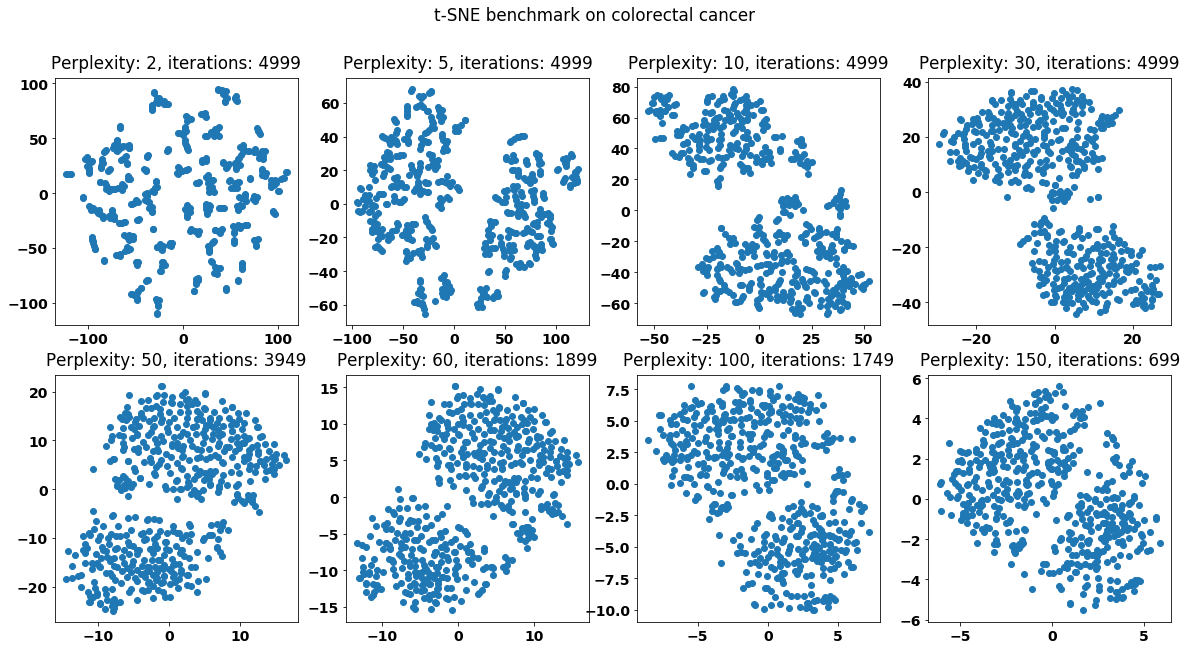

In [192]:
axes = [(i,j) for i in range(2) for j in range(4)]
fig, ax = plt.subplots(2,4, figsize=(20,10))

font = {'family' : 'DejaVu Sans',
        'size'   : 14}

plt.rc('font', **font)

fig.suptitle("t-SNE benchmark on colorectal cancer")


for i,v in sorted(enumerate(datasets.keys())):
    n_iter = datasets[v][1]
    axis=ax[axes[i]]
    axis.scatter(x=datasets[v][0][0],y=datasets[v][0][1])
    title = f'Perplexity: {v}, iterations: {n_iter}'
    axis.set_title(title, pad=10)

As we see from the clusters, the best one so far is definitely the t-SNE with perplexity 50, showing 2 well-defined clusters.

In [307]:
metadata["tsne1"] = datasets[50][0][0]
metadata["tsne2"] = datasets[50][0][1]

Text(0.5, 1.0, 'Tissue of origin')

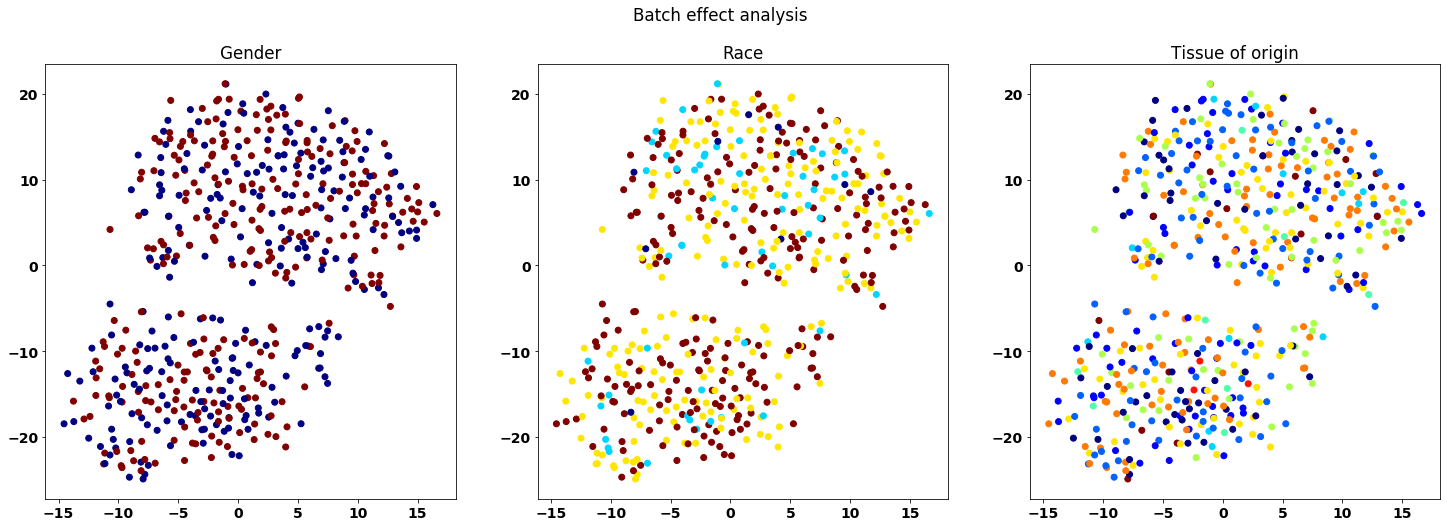

In [278]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()

gender_encoded = label.fit_transform(metadata["gender"])
race_encoded = label.fit_transform(metadata["race"])
tissue_encoded = label.fit_transform(metadata["tissue_or_organ_of_origin"])
# 0 female, 1 male
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(25,8))

fig.suptitle("Batch effect analysis")

ax1.scatter(metadata["tsne1"],metadata["tsne2"], c=gender_encoded, cmap=plt.cm.jet)
ax1.set_title("Gender")
ax2.scatter(metadata["tsne1"],metadata["tsne2"], c=race_encoded, cmap=plt.cm.jet)
ax2.set_title("Race")
ax3.scatter(metadata["tsne1"],metadata["tsne2"], c=tissue_encoded, cmap=plt.cm.jet)
ax3.set_title("Tissue of origin")

Index(['case_id', 'project_id', 'cause_of_death', 'gender', 'year_of_birth',
       'race', 'days_to_birth', 'vital_status', 'days_to_death', 'ethnicity',
       'year_of_death', 'ann_arbor_b_symptoms', 'year_of_diagnosis',
       'ajcc_clinical_t', 'last_known_disease_status', 'method_of_diagnosis',
       'laterality', 'ann_arbor_pathologic_stage', 'primary_diagnosis',
       'tumor_stage', 'classification_of_tumor', 'age_at_diagnosis',
       'morphology', 'ann_arbor_clinical_stage',
       'days_to_last_known_disease_status', 'perineural_invasion_present',
       'ajcc_clinical_n', 'days_to_last_follow_up', 'prior_treatment',
       'ajcc_clinical_m', 'ajcc_pathologic_n', 'ajcc_pathologic_m',
       'tumor_largest_dimension_diameter', 'residual_disease',
       'days_to_recurrence', 'tumor_grade', 'figo_stage',
       'lymphatic_invasion_present', 'tissue_or_organ_of_origin',
       'progression_or_recurrence', 'prior_malignancy',
       'ajcc_staging_system_edition', 'ajcc_patholo

From what we can see, it seems that no batch effect was found relative to sex, race or tissue of origin

In [305]:
metadata = metadata.replace(to_replace=["Stage IIA","Stage IIB","Stage IIC","Stage IID"], value="Stage II")
metadata = metadata.replace(to_replace=['Stage IIIA','Stage IIIB','Stage IIIC','Stage IIID'], value="Stage III")
metadata = metadata.replace(to_replace=['Stage IVA','Stage IVB','Stage IVC'], value="Stage IV")
metadata = metadata.replace(to_replace=['Stage IA','Stage IB'], value="Stage I")
metadata = metadata.replace('--', "Not reported")
pd.unique(metadata["ajcc_pathologic_stage"])

array(['Stage II', 'Stage III', 'Stage IV', 'Stage I', 'Not reported'],
      dtype=object)

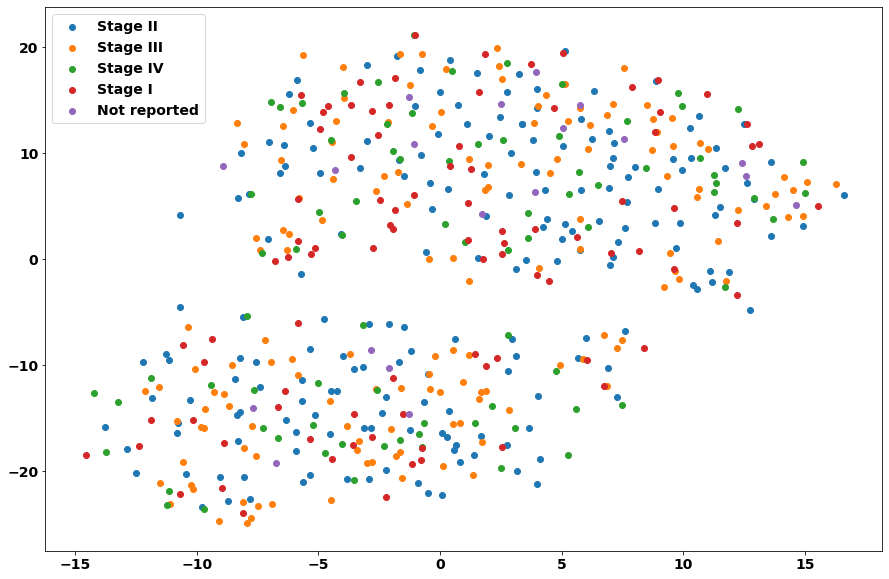

In [309]:
stages = label.fit_transform(metadata["ajcc_pathologic_stage"])
fig, ax = plt.subplots(figsize=(15,10))

for i,stage in enumerate(pd.unique(metadata["ajcc_pathologic_stage"])):
    x = metadata.loc[metadata["ajcc_pathologic_stage"]==stage,"tsne1"]
    y = metadata.loc[metadata["ajcc_pathologic_stage"]==stage,"tsne2"] 
    plt.scatter(x, y, label=stage)

ax.legend()


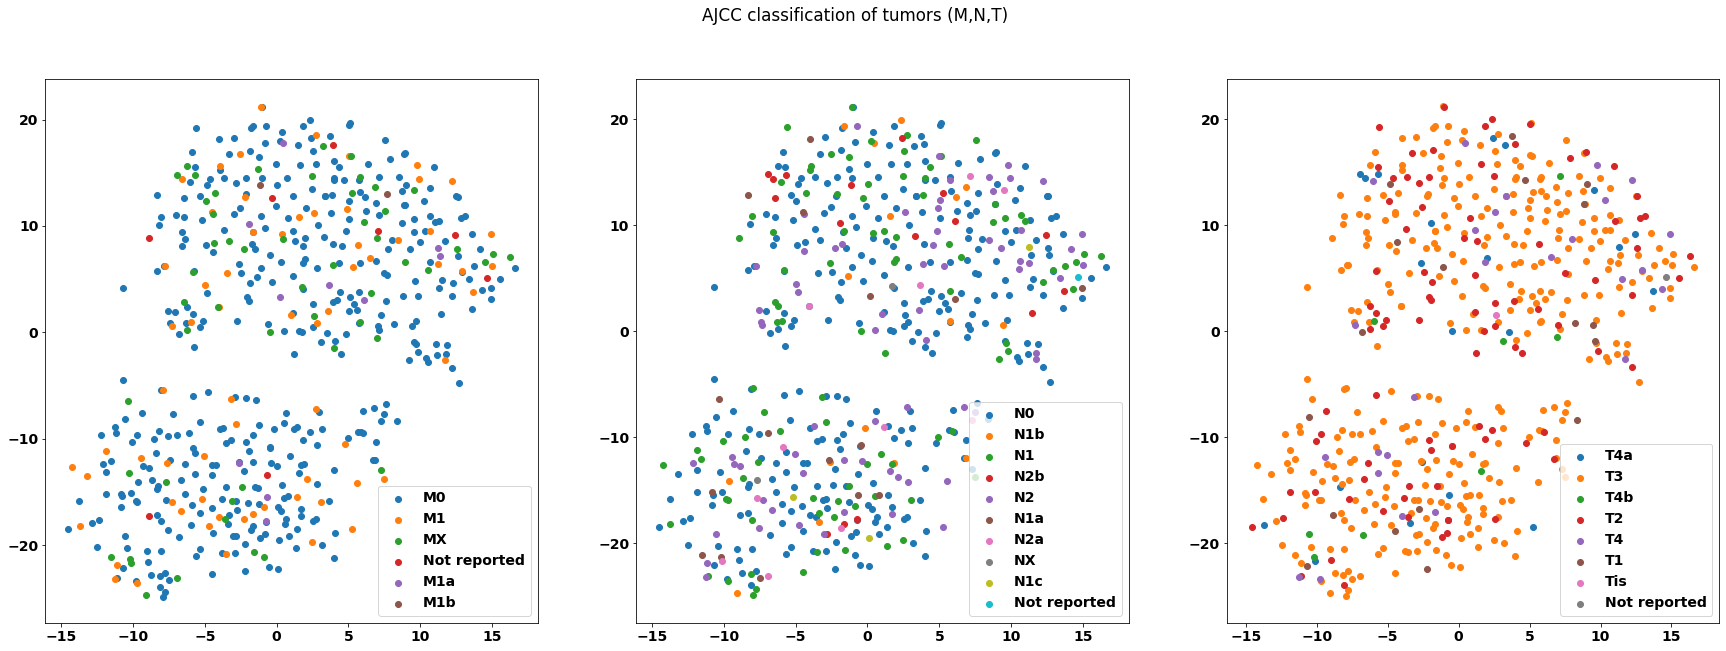

In [315]:
# T, M, N analysis
fig, ax = plt.subplots(1,3, figsize=(30,10))

fig.suptitle("AJCC classification of tumors (M,N,T)")

for i, label in enumerate(["ajcc_pathologic_m","ajcc_pathologic_n","ajcc_pathologic_t"]):
    plot=ax[i]
    
    for j,stage in enumerate(pd.unique(metadata[label])):
        x = metadata.loc[metadata[label]==stage,"tsne1"]
        y = metadata.loc[metadata[label]==stage,"tsne2"] 
        plot.scatter(x, y, label=stage)
    
    plot.legend()

In [261]:
pd.unique(metadata[""])

array(['not reported'], dtype=object)

In [262]:
metadata.columns

Index(['case_id', 'project_id', 'cause_of_death', 'gender', 'year_of_birth',
       'race', 'days_to_birth', 'vital_status', 'days_to_death', 'ethnicity',
       'year_of_death', 'ann_arbor_b_symptoms', 'year_of_diagnosis',
       'ajcc_clinical_t', 'last_known_disease_status', 'method_of_diagnosis',
       'laterality', 'ann_arbor_pathologic_stage', 'primary_diagnosis',
       'tumor_stage', 'classification_of_tumor', 'age_at_diagnosis',
       'morphology', 'ann_arbor_clinical_stage',
       'days_to_last_known_disease_status', 'perineural_invasion_present',
       'ajcc_clinical_n', 'days_to_last_follow_up', 'prior_treatment',
       'ajcc_clinical_m', 'ajcc_pathologic_n', 'ajcc_pathologic_m',
       'tumor_largest_dimension_diameter', 'residual_disease',
       'days_to_recurrence', 'tumor_grade', 'figo_stage',
       'lymphatic_invasion_present', 'tissue_or_organ_of_origin',
       'progression_or_recurrence', 'prior_malignancy',
       'ajcc_staging_system_edition', 'ajcc_patholo